In [1]:
# Import libraries to run LightGBM
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Load the Ames Housing Dataset
data = pd.read_csv("Ames.csv")
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

# Convert categorical columns to "category" dtype
categorical_cols = X.select_dtypes(include=["object"]).columns
X[categorical_cols] = X[categorical_cols].apply(lambda x: x.astype("category"))

# Define the default GBDT model
gbdt_model = lgb.LGBMRegressor(verbose=-1)
gbdt_scores = cross_val_score(gbdt_model, X, y, cv=5)
print(f"Average R^2 score for default Light GBM (with GBDT): {gbdt_scores.mean():.4f}")

# Define the GOSS model
goss_model = lgb.LGBMRegressor(boosting_type="goss", verbose=-1)
goss_scores = cross_val_score(goss_model, X, y, cv=5)
print(f"Average R^2 score for Light GBM with GOSS: {goss_scores.mean():.4f}")

Average R^2 score for default Light GBM (with GBDT): 0.9144
Average R^2 score for Light GBM with GOSS: 0.9121


In [1]:
# Experiment with Leaf-wise Tree Growth
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Load the Ames Housing Dataset
data = pd.read_csv("Ames.csv")
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

# Convert categorical columns to "category" dtype
categorical_cols = X.select_dtypes(include=["object"]).columns
X[categorical_cols] = X[categorical_cols].apply(lambda x: x.astype("category"))

# Define a range of leaf sizes to test
leaf_sizes = [5, 10, 15, 31, 50, 100]

# Results storage
results = {}

# Experiment with different leaf sizes for GBDT
results["GBDT"] = {}
print('Testing different "num_leaves" for GBDT:')
for leaf_size in leaf_sizes:
    model = lgb.LGBMRegressor(boosting_type="gbdt", num_leaves=leaf_size, verbose=-1)
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    results["GBDT"][leaf_size] = scores.mean()
    print(f"num_leaves = {leaf_size}: Average R^2 score = {scores.mean():.4f}")

# Experiment with different leaf sizes for GOSS
results["GOSS"] = {}
print('\nTesting different "num_leaves" for GOSS:')
for leaf_size in leaf_sizes:
    model = lgb.LGBMRegressor(boosting_type="goss", num_leaves=leaf_size, verbose=-1)
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    results["GOSS"][leaf_size] = scores.mean()
    print(f"num_leaves = {leaf_size}: Average R^2 score = {scores.mean():.4f}")

Testing different "num_leaves" for GBDT:
num_leaves = 5: Average R^2 score = 0.9151
num_leaves = 10: Average R^2 score = 0.9194
num_leaves = 15: Average R^2 score = 0.9176
num_leaves = 31: Average R^2 score = 0.9144
num_leaves = 50: Average R^2 score = 0.9118
num_leaves = 100: Average R^2 score = 0.9106

Testing different "num_leaves" for GOSS:
num_leaves = 5: Average R^2 score = 0.9148
num_leaves = 10: Average R^2 score = 0.9163
num_leaves = 15: Average R^2 score = 0.9142
num_leaves = 31: Average R^2 score = 0.9121
num_leaves = 50: Average R^2 score = 0.9121
num_leaves = 100: Average R^2 score = 0.9116


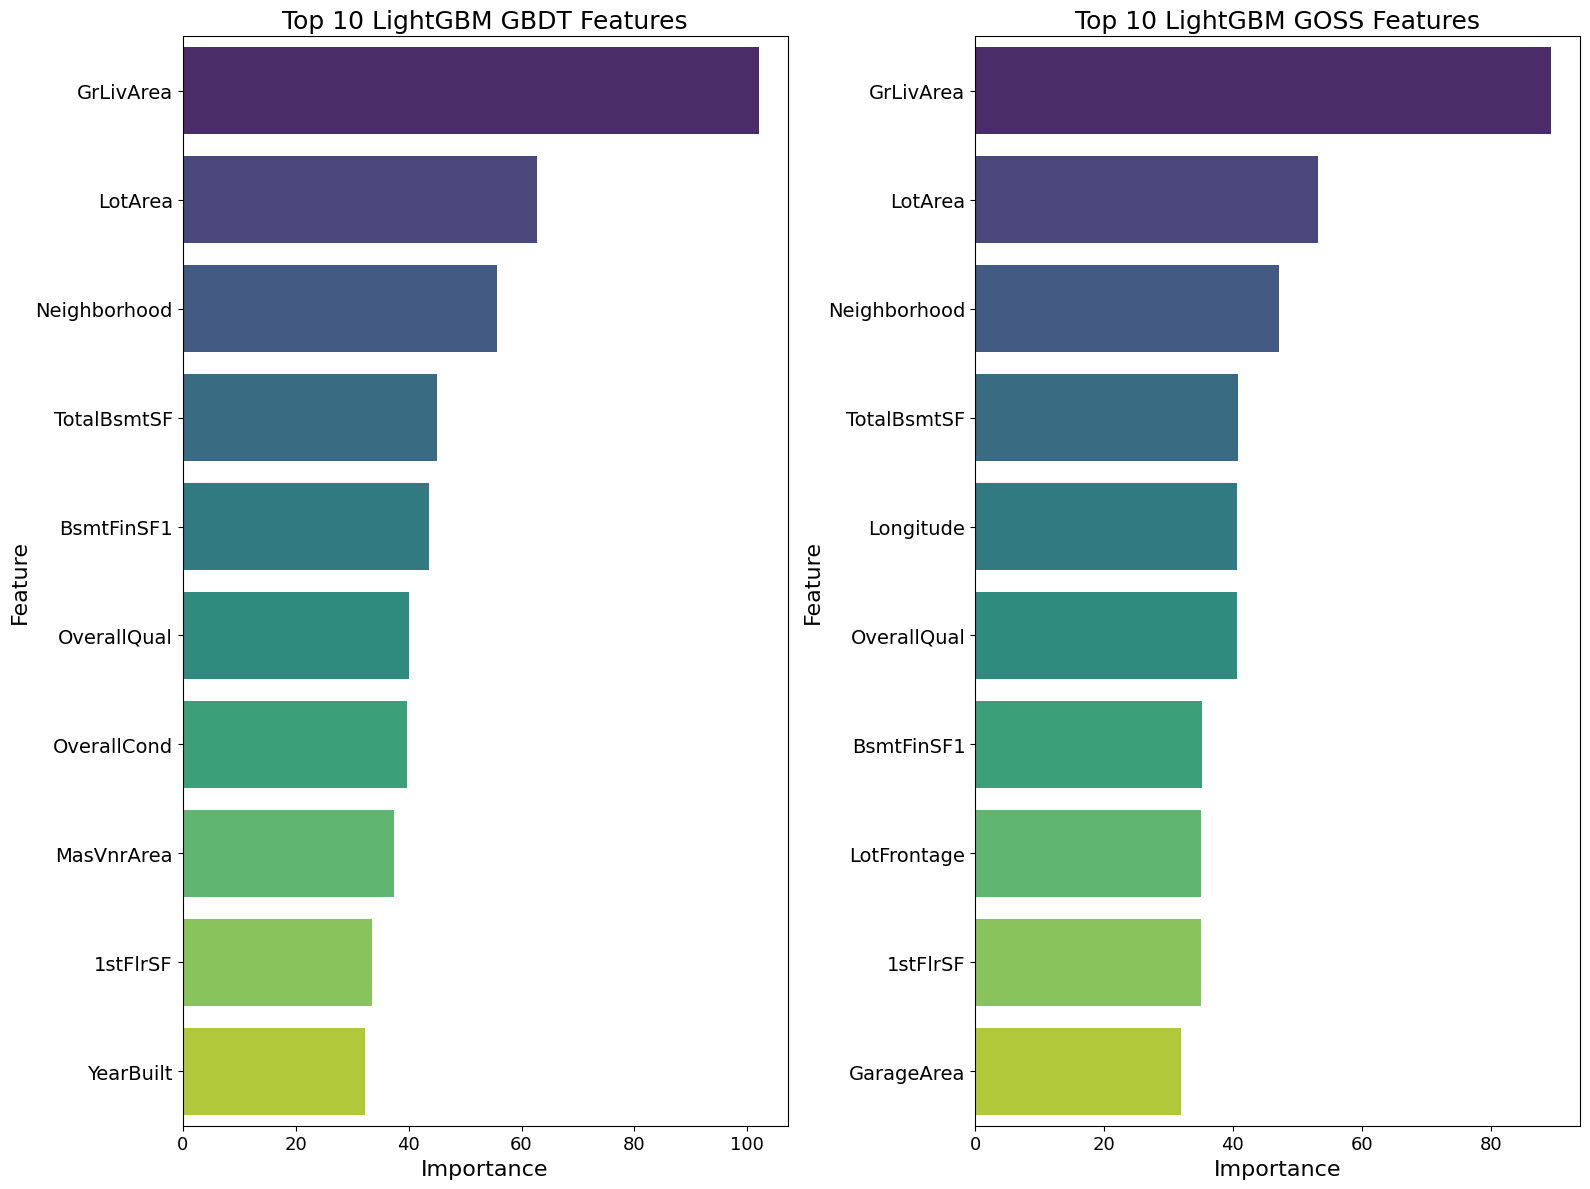

In [3]:
# Importing libraries to compare feature importance between GBDT and GOSS:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
data = pd.read_csv("Ames.csv")
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

categorical_cols = X.select_dtypes(include=["object"]).columns
X[categorical_cols] = X[categorical_cols].apply(lambda x: x.astype("category"))

# Set up K-fold cross-validation
kf = KFold(n_splits=5)
gbdt_feature_importances = []
goss_feature_importances = []

# Iterate over each split
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train GBDT model with optimal num_leaves
    gbdt_model = lgb.LGBMRegressor(boosting_type="gbdt", num_leaves=10, verbose=-1)
    gbdt_model.fit(X_train, y_train)
    gbdt_feature_importances.append(gbdt_model.feature_importances_)

    # Train GOSS model with optimal num_leaves
    goss_model = lgb.LGBMRegressor(boosting_type="goss", num_leaves=10, verbose=-1)
    goss_model.fit(X_train, y_train)
    goss_feature_importances.append(goss_model.feature_importances_)

# Average feature importance across all folds for each model
avg_gbdt_feature_importance = np.mean(gbdt_feature_importances, axis=0)
avg_goss_feature_importance = np.mean(goss_feature_importances, axis=0)

# Convert to DataFrame
feat_importances_gbdt = pd.DataFrame({
    "Feature": X.columns,
    "Importance": avg_gbdt_feature_importance
})
feat_importances_goss = pd.DataFrame({
    "Feature": X.columns,
    "Importance": avg_goss_feature_importance
})

# Sort and take the top 10 features
top_gbdt_features = feat_importances_gbdt.sort_values(by="Importance", ascending=False).head(10)
top_goss_features = feat_importances_goss.sort_values(by="Importance", ascending=False).head(10)

# Plotting
plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
sns.barplot(data=top_gbdt_features, y="Feature", x="Importance",
            hue="Feature", orient="h", legend=False, palette="viridis")
plt.title("Top 10 LightGBM GBDT Features", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
sns.barplot(data=top_goss_features, y="Feature", x="Importance",
            hue="Feature", orient="h", legend=False, palette="viridis")
plt.title("Top 10 LightGBM GOSS Features", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()